# Model Datasets

Datasets used for parameterization and backtesting

Sections based on rows of `20220721_Fei Protocol Model Datasets_vDraft` spreadsheet

In [1]:
import asyncio

import matplotlib.pyplot as plt
import numpy as np
import toolplot

from ctc import evm
from ctc import rpc
from ctc.protocols import aave_v2_utils
from ctc.protocols import compound_utils
from ctc.protocols import chainlink_utils
from ctc.protocols import fei_utils
from ctc.protocols.fei_utils import fei_psms
from ctc.protocols import rari_utils
from ctc.toolbox import plot_utils

%matplotlib inline

In [2]:
toolplot.setup_plot_formatting()

In [3]:
n_samples = 200

latest_block_number = await evm.async_get_latest_block_number()

## Protocol, PCV, and FEI Distribution

In [4]:
fei_analytics_payload = await fei_utils.async_create_payload(
    timescale='180d,2d',
)

In [5]:
fei_analytics_payload['data'].keys()

dict_keys(['pcv_by_asset', 'prices', 'dex_tvls', 'pfei_by_platform', 'buybacks', 'pcv_stats', 'circulating_fei'])

#### Historical PSM FEI minting / redemption rates

In [6]:
mints = await fei_psms.async_get_fei_psm_mints()

mints

,block_hash,transaction_hash,contract_address,event_name,arg__to,arg__amountIn,arg__amountFeiOut,address,event_hash,token,timestamp,fei_per_token,token_per_fei
block_number,,,,,,,,,,,,,
14010071,0x8b3895888e7f64b18c6359cb41c890a91e8767f4d0e3...,0x764ad8679fa9abd06cffad0d9de1f5979c78bccf0070...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Mint,0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,2.623412e+20,8.648496e+05,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,ETH,1642250455,3296.659395,0.000303
14016801,0xedecfbe8627ba3842f7879db18ae648fe7425dda0164...,0xd3653f57f908782573583d76c2cf610c8751e38a100d...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Mint,0x8c54aa2a32a779e6f6fbea568ad85a19e0109c26,2.522479e+20,8.325772e+05,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,ETH,1642339729,3300.630774,0.000303
14020471,0x1f1fb8e9a98645830ffea16c8769d3e9887b4ddb16fc...,0x18cc93f01b0ceb4215116633b512bd24efadb02d44dc...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Mint,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,2.889185e+18,9.530851e+03,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,ETH,1642388337,3298.802473,0.000303
14033600,0xf3ba930bf8bd62481fa977053922f151d696d13f316e...,0xc473a93636311598b0b5876ddba33e229f1dc44eeade...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Mint,0xa10fca31a2cb432c9ac976779dc947cfdb003ef0,1.238761e+20,3.880907e+05,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,ETH,1642563401,3132.895069,0.000319
14033601,0xdc7eab7bed3aa80834dbcb46cdc2275f840ad68a87b4...,0xed4502ebe234cecc4bd2a64991adad7db1099b3ce279...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Mint,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,4.727397e+20,1.481044e+06,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,ETH,1642563406,3132.895069,0.000319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15194399,0xd578923d6c4693b43b35cebb941bd4a1164007f57b37...,0x4833b4c7edc62cbe724a397b2231a7a3fb8e764f1a8f...,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,Mint,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,4.768430e+21,4.766999e+03,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,DAI,1658519161,0.999700,1.000300
15196782,0x95f8074a0bbf6edff315a1c6f8b57b4653701c060688...,0x67f8468b007d6061407b8a67d1608556c2b4a32ab3b3...,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,Mint,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,1.511319e+22,1.510866e+04,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,DAI,1658550676,0.999700,1.000300
15197637,0x7a8eaea97e3f8d31bb9f23a01909817518f876b99c98...,0xb2a4d4cd93592b258214fbd8ac2f2514033af934c423...,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,Mint,0xdf50fbde8180c8785842c8e316ebe06f542d3443,1.603416e+23,1.602935e+05,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,0x4c209b5fc8ad50758f13e2e1088ba56a560dff690a1c...,DAI,1658561759,0.999700,1.000300


In [7]:
redemptions = await fei_psms.async_get_fei_psm_redemptions()

redemptions

,block_hash,transaction_hash,contract_address,event_name,arg__to,arg__amountFeiIn,arg__amountAssetOut,address,event_hash,token,timestamp,fei_per_token,token_per_fei
block_number,,,,,,,,,,,,,
14055648,0xddffd920b635f7d11429cd68a73b9306b1ef7ec55afc...,0x83002b3b838d908736036cc4e5ca8b1d8d2d109a68a5...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Redeem,0x1c073d5045b1abb6924d5f0f8b2f667b1653a4c3,5.134144e+05,2.048995e+20,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,ETH,1642857417,2505.688545,0.000399
14055691,0xef225c24dbcabc94de42a2c922e1500012f5f3d2f7f2...,0x7150b8028c7c81819ea950e444c2af4fcfc54b1a5b6e...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Redeem,0x4e474b76c3f09dff4cc493802462e780c6515449,3.333333e-09,1.323303e+06,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,ETH,1642857957,2518.949427,0.000397
14056388,0xceffe9ce41088e68ae03cfb5a00dd0ee2618ad04fb1e...,0x75cb9ed24d247d50e46dc3161ccd9d3bd89b029a2a23...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Redeem,0x1c073d5045b1abb6924d5f0f8b2f667b1653a4c3,2.826846e+05,1.178749e+20,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,ETH,1642867728,2398.174833,0.000417
14056395,0xdab37547be9556488c4120293407c42bc0d9021a5c35...,0xa0d6de7c7e10662f8d9bf27bd2ca1e1fa8884a79e24a...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Redeem,0x1c073d5045b1abb6924d5f0f8b2f667b1653a4c3,3.419141e+05,1.425726e+20,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,ETH,1642867765,2398.174833,0.000417
14056397,0xf4a277a679fffc3352b5db5956dfe03c36925514f88a...,0xabc1dab9158c1613d8a1907db8c5fb301ea983ede8cb...,0x98e5f5706897074a4664dd3a32eb80242d6e694b,Redeem,0x3f3df535f180d3da8cee3e9eee6465dc7a79f499,1.182568e+05,4.931118e+19,0x98e5f5706897074a4664dd3a32eb80242d6e694b,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,ETH,1642867790,2398.174833,0.000417
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15139003,0x025d45cbfa05d563508251cc704baa696e937636b7d1...,0xf44ec1ad27f31979827e15afff15227b6dd36ad4e588...,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,Redeem,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,4.287202e+04,4.285916e+22,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,DAI,1657779177,1.000300,0.999700
15149446,0x9c42587ac9517f300eaf6ffb78ac80e412982c809f5b...,0xd66b4adb9ea58fde11f041a3e3e863347b295cf5e1d8...,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,Redeem,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,5.036060e+04,5.034549e+22,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,DAI,1657917184,1.000300,0.999700
15150585,0xc6b0469d51511487dd7f25048306dd7798b4856bf124...,0xbc39e6460dd7b2f19e3b17fe5d5f266bd96d5fa329ec...,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,Redeem,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,1.732530e+05,1.732010e+23,0x2a188f9eb761f70ecea083ba6c2a40145078dfc2,0xe5b754fb1abb7f01b499791d0b820ae3b6af3424ac1c...,DAI,1657932757,1.000300,0.999700


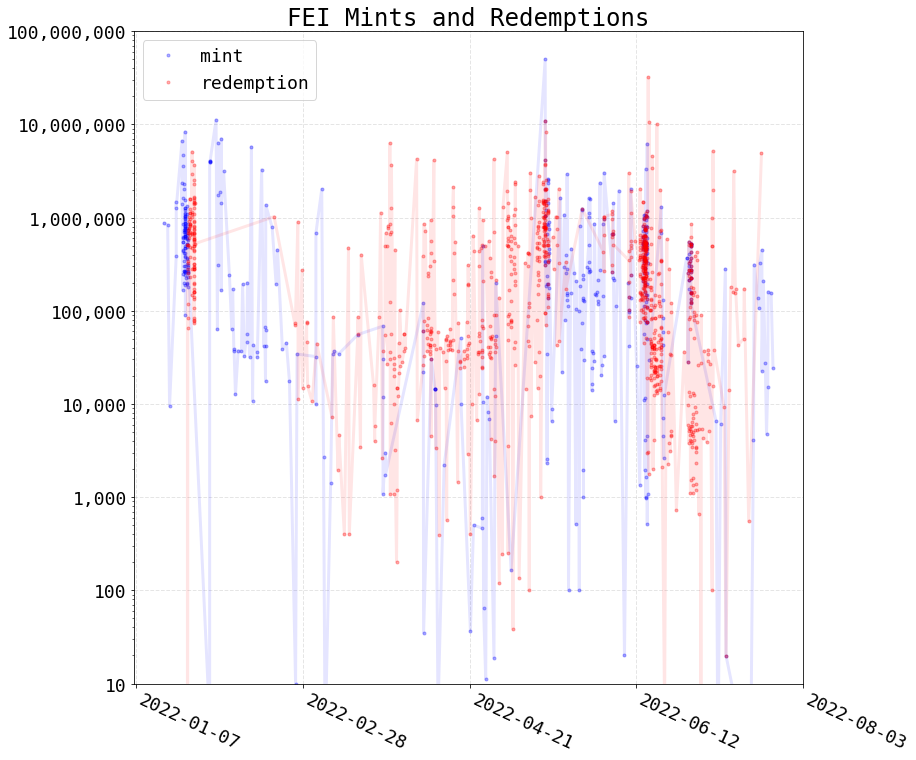

In [8]:
plt.plot(mints['arg__amountFeiOut'], '.b', alpha=0.3, label='mint')
plt.plot(mints['arg__amountFeiOut'], '-b', alpha=0.1)

plt.plot(redemptions['arg__amountFeiIn'], '.r', alpha=0.3, label='redemption')
plt.plot(redemptions['arg__amountFeiIn'], '-r', alpha=0.1)

plt.yscale('log')
plt.ylim([10, 100e6])

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks()
plt.title('FEI Mints and Redemptions')
plt.show()

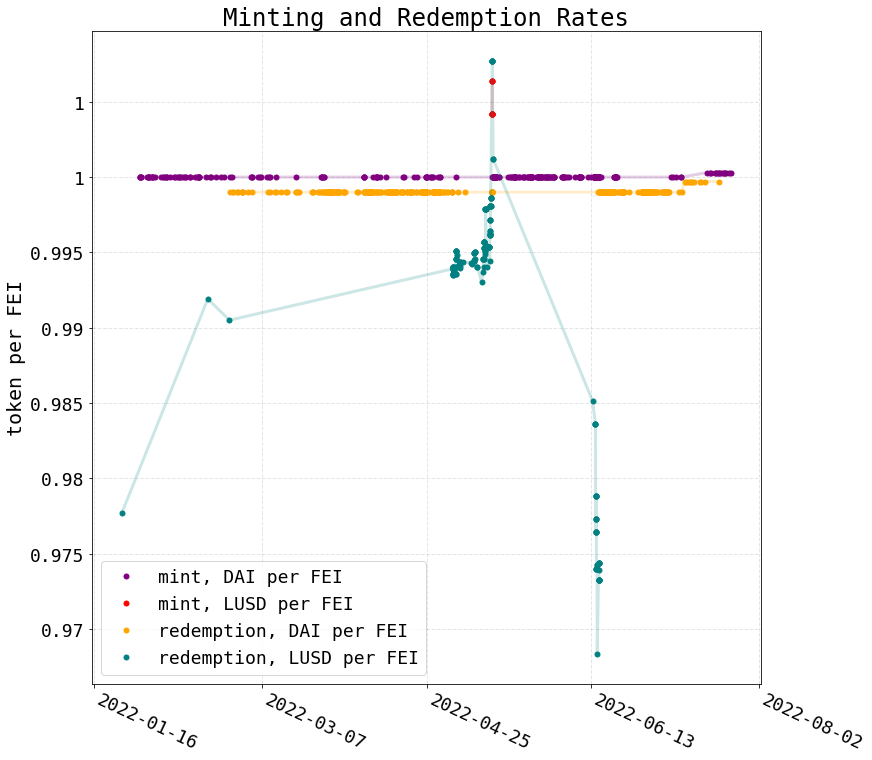

In [9]:
markersize = 10

mask = mints['token'] == 'DAI'
plt.plot(mints['token_per_fei'][mask], '.', markersize=markersize, color='purple', label='mint, DAI per FEI')
plt.plot(mints['token_per_fei'][mask], '-', color='purple', alpha=0.2)

mask = mints['token'] == 'LUSD'
plt.plot(mints['token_per_fei'][mask], '.', markersize=markersize, color='red', label='mint, LUSD per FEI')
plt.plot(mints['token_per_fei'][mask], '-', color='red', alpha=0.2)

mask = redemptions['token'] == 'DAI'
plt.plot(redemptions['token_per_fei'][mask], '.', markersize=markersize, color='orange', label='redemption, DAI per FEI')
plt.plot(redemptions['token_per_fei'][mask], '-', color='orange', alpha=0.2)

mask = redemptions['token'] == 'LUSD'
plt.plot(redemptions['token_per_fei'][mask], '.', markersize=markersize, color='teal', label='redemption, LUSD per FEI')
plt.plot(redemptions['token_per_fei'][mask], '-', color='teal', alpha=0.2)

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend(loc='lower left')
toolplot.format_yticks()
plt.title('Minting and Redemption Rates')
plt.ylabel('token per FEI')
plt.show()

#### Historical PCV distribution across all assets and locations

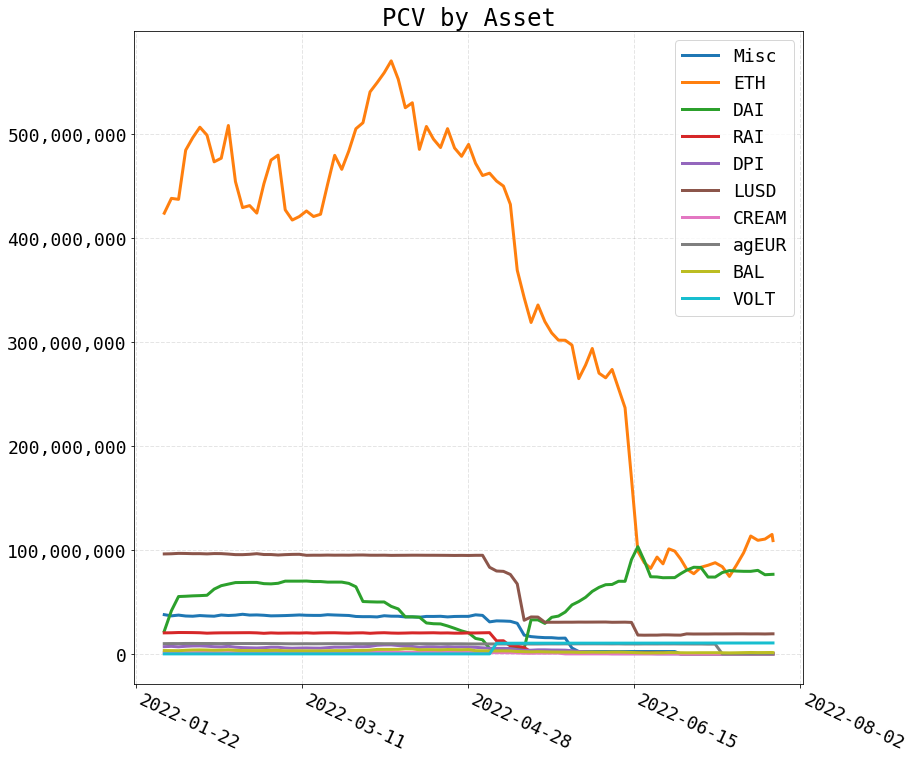

In [10]:
for asset, asset_data in fei_analytics_payload['data']['pcv_by_asset']['metrics'].items():
    plt.plot(fei_analytics_payload['block_numbers'], asset_data['values'], label=asset)
    
await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks()
plt.title('PCV by Asset')
plt.show()

#### Historical protocol-owned FEI distribution

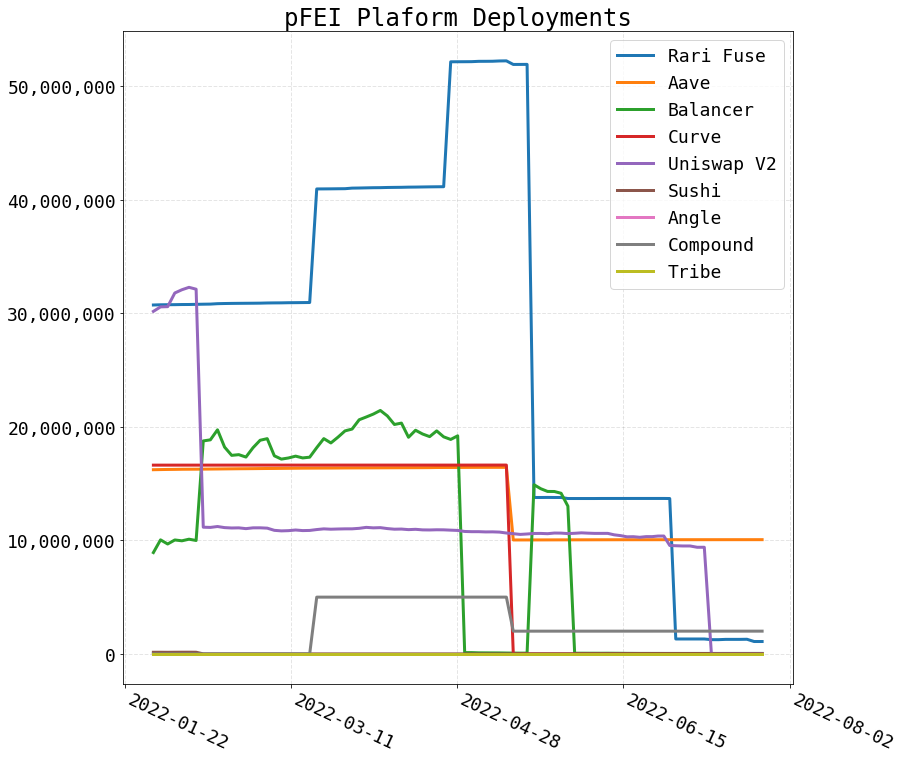

In [11]:
for platform, pfei in fei_analytics_payload['data']['pfei_by_platform']['metrics'].items():
    if platform in ['Fei', 'Other', 'OA Account']:
        continue
    plt.plot(fei_analytics_payload['block_numbers'], pfei['values'], label=platform)

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks()
plt.title('pFEI Plaform Deployments')
plt.show()

#### Historical user-circulating FEI distribution

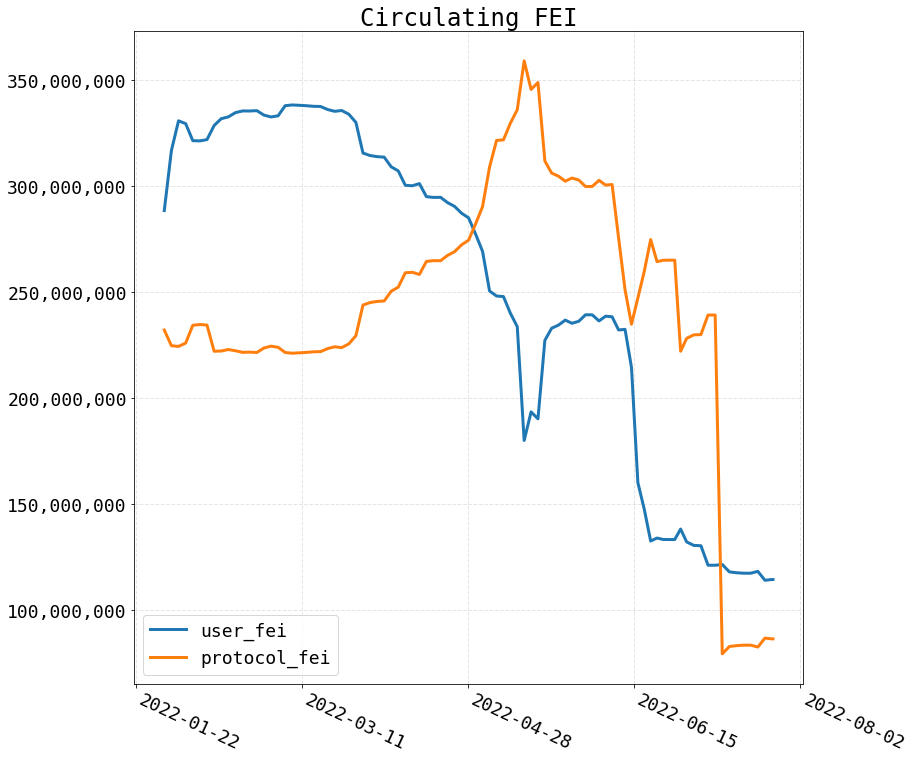

In [12]:
for key, value in fei_analytics_payload['data']['circulating_fei']['metrics'].items():
    plt.plot(fei_analytics_payload['block_numbers'], value['values'], label=key)

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks()
plt.title('Circulating FEI')
plt.show()

## Asset Prices

#### Historical benchmark / basket for Stable Asset price

In [13]:
dai_usd = await chainlink_utils.async_get_feed_data('DAI_USD', interpolate=True)

dai_usd

performing meta-aggregation


block_number
10843199    1.038150
10843200    1.036300
10843201    1.036300
10843202    1.036300
10843203    1.036300
              ...   
15210148    1.000442
15210149    1.000442
15210150    1.000442
15210151    1.000442
15210152    1.000442
Name: answer, Length: 4366954, dtype: float64

In [14]:
lusd_usd = await chainlink_utils.async_get_feed_data('LUSD_USD', interpolate=True)

lusd_usd

block_number
13046006    1.003362
13046007    1.003362
13046008    1.003362
13046009    1.003362
13046010    1.003362
              ...   
15210148    1.029258
15210149    1.029258
15210150    1.029258
15210151    1.029258
15210152    1.029258
Name: answer, Length: 2164147, dtype: float64

In [15]:
usdc_usd = await chainlink_utils.async_get_feed_data('USDC_USD', interpolate=True)

usdc_usd

performing meta-aggregation


block_number
11872594    0.999950
11872595    0.999950
11872596    0.999950
11872597    0.999950
11872598    0.999950
              ...   
15210150    1.000091
15210151    1.000091
15210152    1.000091
15210153    1.000091
15210154    1.000091
Name: answer, Length: 3337561, dtype: float64

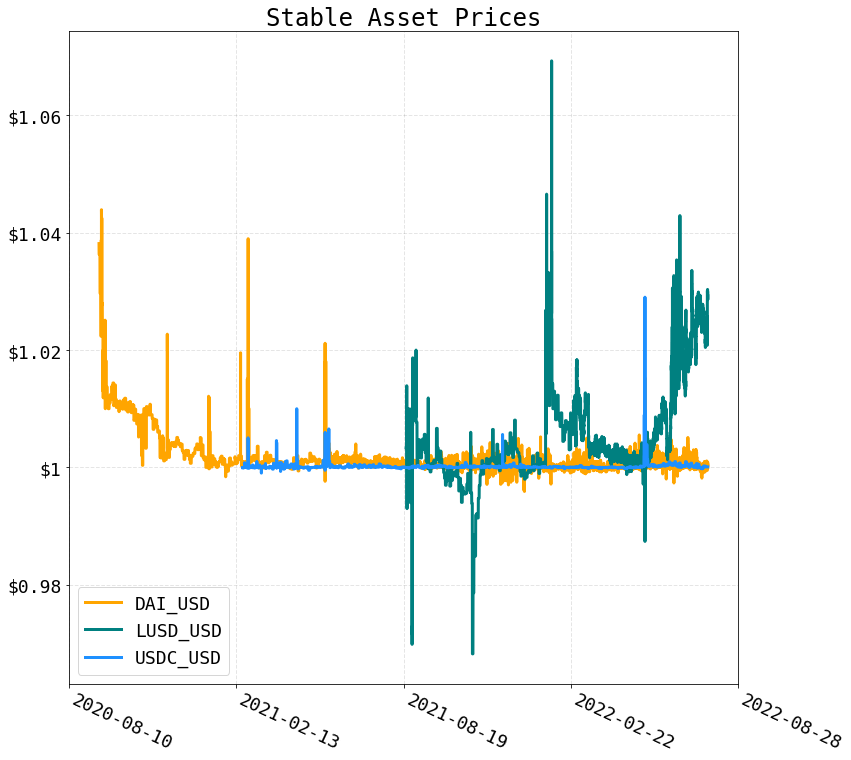

In [16]:
plt.plot(dai_usd, color='orange', label='DAI_USD')
plt.plot(lusd_usd, color='teal', label='LUSD_USD')
plt.plot(usdc_usd, color='dodgerblue', label='USDC_USD')

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks(toolstr_kwargs={'prefix': '$'})
plt.title('Stable Asset Prices')
plt.show()

#### Historical ETH price

In [17]:
eth_usd = await chainlink_utils.async_get_feed_data('ETH_USD', interpolate=True)

eth_usd

performing meta-aggregation


block_number
10606572     399.330000
10606573     399.320000
10606574     399.325000
10606575     399.320000
10606576     399.320000
               ...     
15210151    1516.447699
15210152    1516.447699
15210153    1516.447699
15210154    1516.447699
15210155    1516.447699
Name: answer, Length: 4603584, dtype: float64

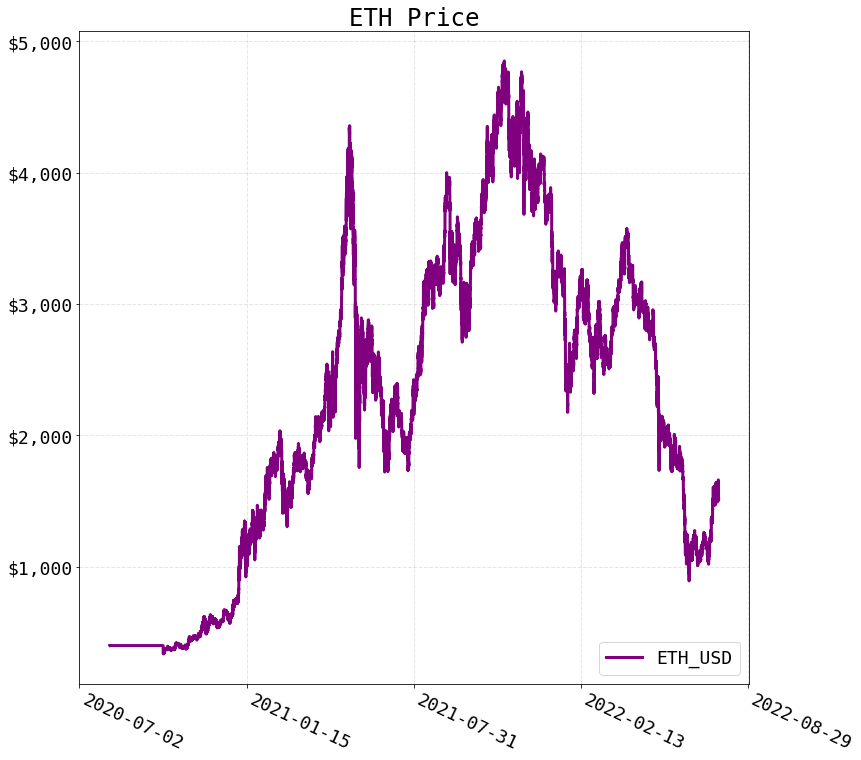

In [18]:
plt.plot(eth_usd, color='purple', label='ETH_USD')

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks(toolstr_kwargs={'prefix': '$'})
plt.title('ETH Price')
plt.show()

#### Historical FEI price

In [19]:
fei_usd = await chainlink_utils.async_get_feed_data('FEI_USD', interpolate=True)

fei_usd

block_number
12907805    1.005519
12907806    1.005519
12907807    1.005519
12907808    1.005519
12907809    1.005519
              ...   
15210151    0.997466
15210152    0.997466
15210153    0.997466
15210154    0.997466
15210155    0.997466
Name: answer, Length: 2302351, dtype: float64

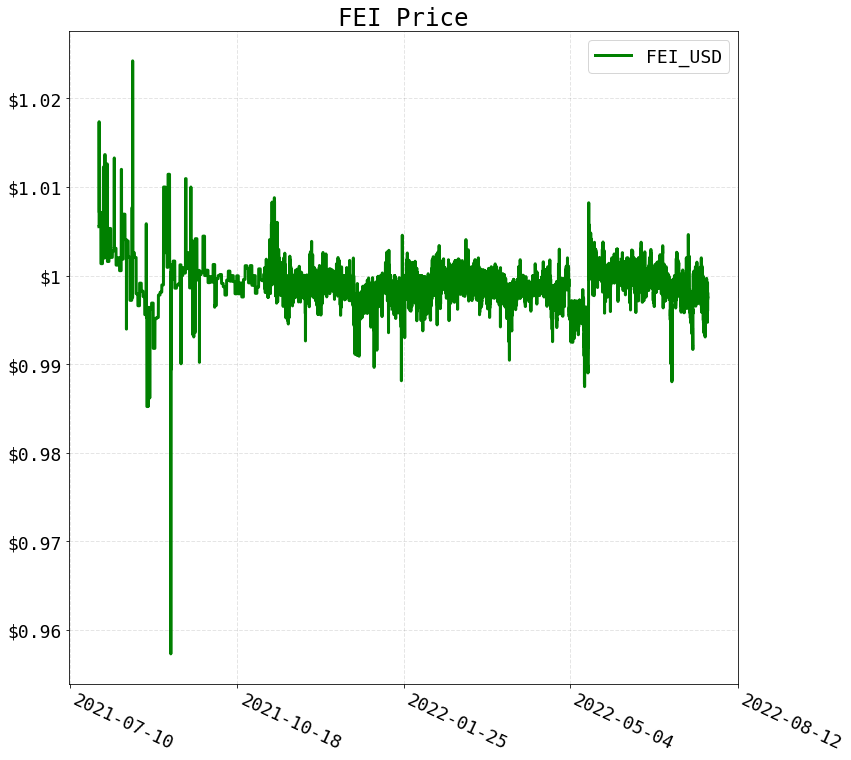

In [20]:
plt.plot(fei_usd, color='green', label='FEI_USD')

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks(toolstr_kwargs={'prefix': '$'})
plt.title('FEI Price')
plt.show()

## Asset Yield

#### Historical benchmark / basket for Stable Asset yield

In [21]:
# compound dai

cdai = '0x5d3a536e4d6dbd6114cc1ead35777bab948e3643'
cdai_creation_block = await evm.async_get_contract_creation_block(cdai)
cdai_blocks = np.linspace(cdai_creation_block, latest_block_number, n_samples).astype(int)
cdai_yields = await compound_utils.async_get_supply_apy_by_block(ctoken=cdai, blocks=cdai_blocks)

In [22]:
# compound usdc

cusdc = '0x39aa39c021dfbae8fac545936693ac917d5e7563'
cusdc_creation_block = await evm.async_get_contract_creation_block(cdai)
cusdc_blocks = np.linspace(cusdc_creation_block, latest_block_number, n_samples).astype(int)
cusdc_yields = await compound_utils.async_get_supply_apy_by_block(ctoken=cusdc, blocks=cusdc_blocks)

In [23]:
usdc = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
dai = '0x6b175474e89094c44da98b954eedeac495271d0f'
fei = '0x956f47f50a910163d8bf957cf5846d573e7f87ca'

aave_v2_creation_block = await evm.async_get_contract_creation_block(
    aave_v2_utils.aave_interest_rates.aave_lending_pool,
)
aave_sample_blocks = np.linspace(aave_v2_creation_block, latest_block_number, n_samples).astype(int)

# aUSDC
ausdc_rates = await aave_v2_utils.async_get_interest_rates_by_block(
    token=usdc,
    blocks=aave_sample_blocks,
)
ausdc_yields = ausdc_rates['supply_apy']

# aDAI
adai_rates = await aave_v2_utils.async_get_interest_rates_by_block(
    token=dai,
    blocks=aave_sample_blocks,
)
adai_yields = adai_rates['supply_apy']

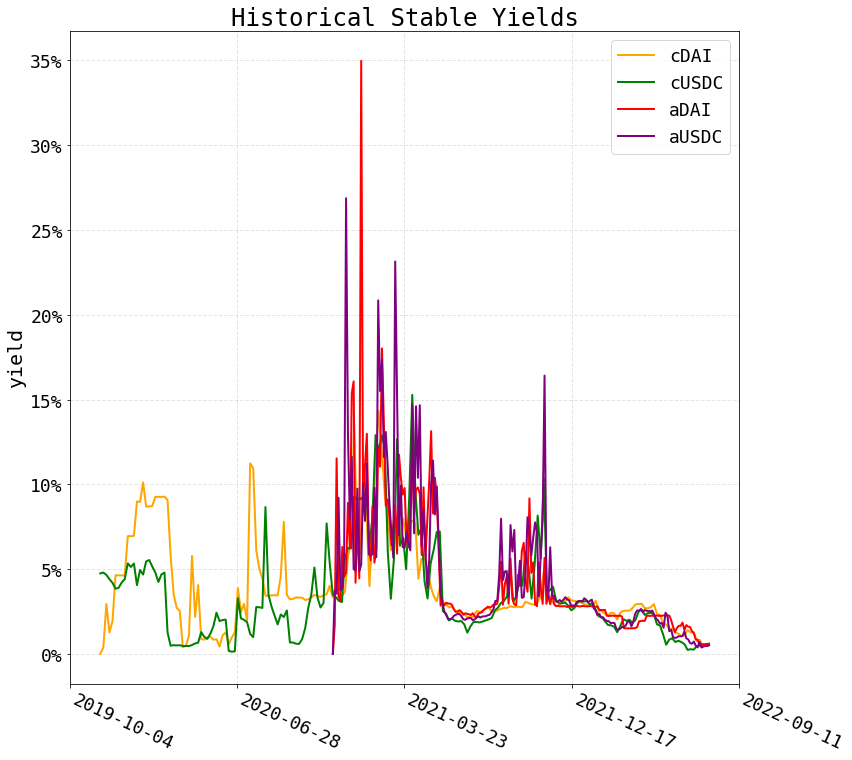

In [24]:
linewidth = 2
plt.plot(cdai_blocks, cdai_yields, color='orange', label='cDAI', linewidth=linewidth)
plt.plot(cusdc_blocks, cusdc_yields, color='green', label='cUSDC', linewidth=linewidth)
plt.plot(aave_sample_blocks, adai_yields, color='red', label='aDAI', linewidth=linewidth)
plt.plot(aave_sample_blocks, ausdc_yields, color='purple', label='aUSDC', linewidth=linewidth)


await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks(toolstr_kwargs={'percentage': True})
plt.ylabel('yield')
plt.title('Historical Stable Yields')
plt.show()

#### Historical ETH staking yield

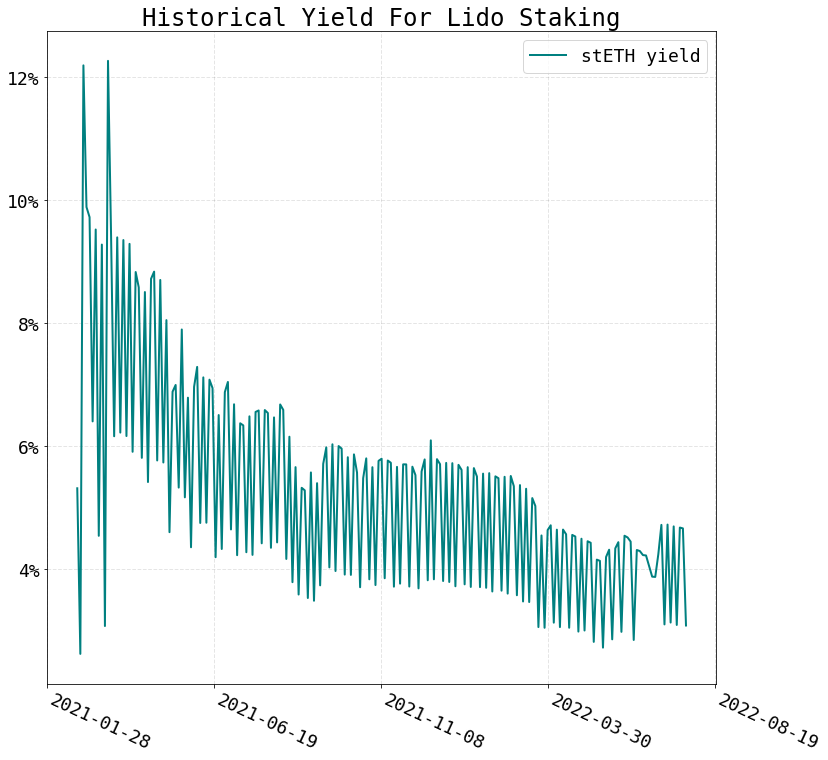

In [25]:
# compute staking rates of staking via lido

wsteth = '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0'

# compute timepoint samples
wsteth_creation_block = await evm.async_get_contract_creation_block(wsteth)
wsteth_blocks = np.linspace(wsteth_creation_block, latest_block_number, n_samples).astype(int)
wsteth_block_timestamps = await evm.async_get_block_timestamps(wsteth_blocks)
wsteth_block_timestamps = np.array(wsteth_block_timestamps)

# compute growth at each timepoint
steth_per_token = await rpc.async_batch_eth_call(
    to_address=wsteth,
    function_name='stEthPerToken',
    block_numbers=wsteth_blocks,
    provider={'chunk_size': 1},
)
steth_per_token = np.array(steth_per_token)

# convert to apy
wsteth_time_intervals = wsteth_block_timestamps[1:] - wsteth_block_timestamps[:-1]
wsteth_growth_intervals = steth_per_token[1:] / steth_per_token[:-1]
seconds_per_year = 86400 * 365
years_per_interval = wsteth_time_intervals / seconds_per_year
wsteth_apy = np.exp(np.log(wsteth_growth_intervals) / years_per_interval)

# plot
plt.plot(wsteth_blocks[1:], wsteth_apy - 1, linewidth=2, color='teal', label='stETH yield')
await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks(toolstr_kwargs={'percentage': True})
plt.title('Historical Yield For Lido Staking')
plt.show()

## Capital Allocation Model

####  \<Yield and risk parameters>

## FEI Savings Deposit

#### Historical benchmark / basket for FEI Savings Rate yield

In [26]:
# cFEI
cfei = '0x7713dd9ca933848f6819f38b8352d9a15ea73f67'
cfei_creation_block = await evm.async_get_contract_creation_block(cfei)
cfei_blocks = np.linspace(cfei_creation_block, latest_block_number, n_samples).astype(int)
cfei_yields = await compound_utils.async_get_supply_apy_by_block(ctoken=cfei, blocks=cfei_blocks)

# aFEI
afei_rates = await aave_v2_utils.async_get_interest_rates_by_block(
    token=fei,
    blocks=aave_sample_blocks,
)
afei_yields = adai_rates['supply_apy']

# fFEI (rari fuse)
ffei = '0xd8553552f8868c1ef160eedf031cf0bcf9686945'
ffei_creation_block = await evm.async_get_contract_creation_block(ffei)
ffei_blocks = np.linspace(ffei_creation_block + 450000, latest_block_number, n_samples).astype(int)
coroutines = [
    rari_utils.async_get_supply_apy(ctoken=ffei, block=block)
    for block in ffei_blocks
]
ffei_supply_apy = await asyncio.gather(*coroutines)

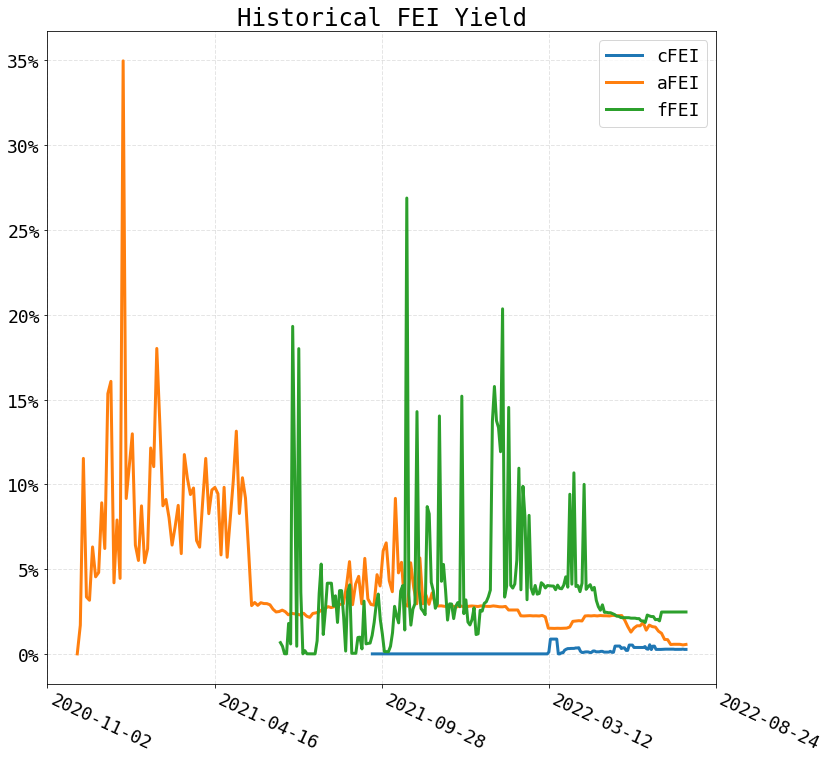

In [27]:
plt.plot(cfei_blocks, cfei_yields, label='cFEI')
plt.plot(aave_sample_blocks, afei_yields, label='aFEI')
plt.plot(ffei_blocks, ffei_supply_apy, label='fFEI')

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks(toolstr_kwargs={'percentage': True})
plt.title('Historical FEI Yield')
plt.show()

## Liquidity Pools

#### Historical FEI Balancer liquidity (Uniswap etc. minor)

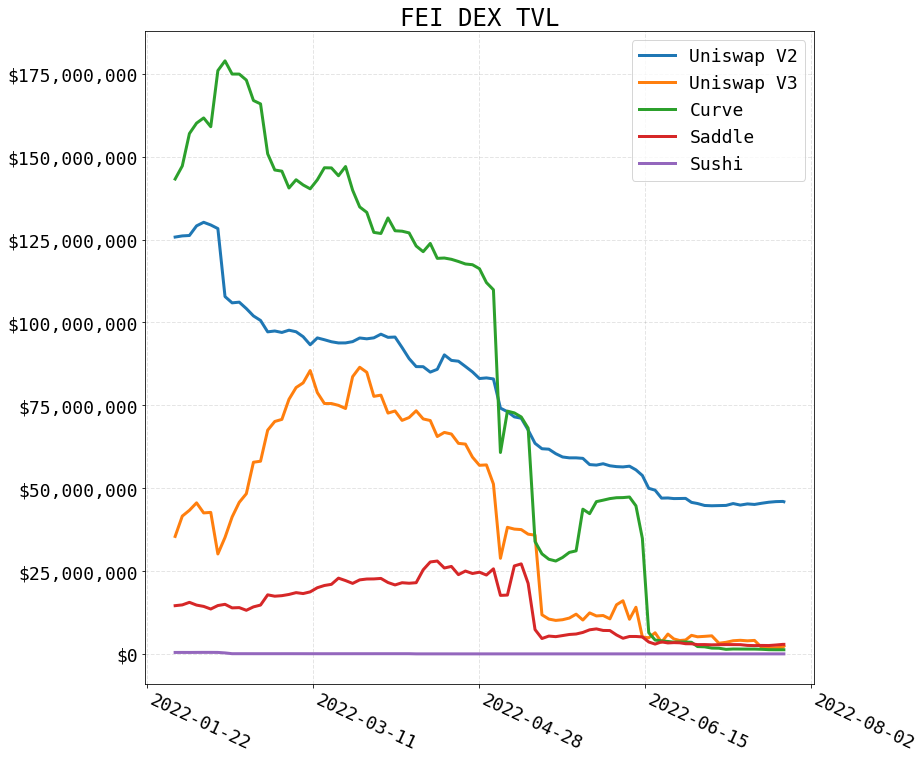

In [28]:
for platform, platform_tvl in fei_analytics_payload['data']['dex_tvls']['metrics'].items():
    plt.plot(fei_analytics_payload['block_numbers'], platform_tvl['values'], label=platform)

await plot_utils.async_xtick_block_dates()
toolplot.add_tick_grid()
plt.legend()
toolplot.format_yticks(toolstr_kwargs={'prefix': '$'})
plt.title('FEI DEX TVL')
plt.show()

## Money Markets

#### Historical Aave, Compound supply / borrow rates and utilization

In [29]:
# see above